# Treść zadania

1. Napisać program, który uruchamia 2 wątki, z których jeden zwiększa wartość zmiennej
   całkowitej o 1, drugi wątek zmniejsza wartość o 1. Zakładając, że na początku wartość
   zmiennej Counter była 0, chcielibyśmy wiedzieć jaka będzie wartość tej zmiennej po
   wykonaniu 10000 operacji zwiększania i zmniejszania przez obydwa wątki.  

2. Na podstawie 100 wykonań programu z p.1, stworzyć histogram końcowych wartości
   zmiennej Counter.

3. Spróbować wprowadzić mechanizm do programu z p.1, który zagwarantowałby przewidywalną
   końcową wartość zmiennej Counter. Nie używać żadnych systemowych mechanizmów, tylko
   swój autorski.

4. Napisać sprawozdanie z realizacji pp. 1-3, z argumentacją i interpretacją wyników.

# Rozwiązanie

Poniżej znajdują się 2 rozwiązania: pierwsze jest implementacją punktów 1 i 2, z kolei
drugie jest realizacją punktu 3.

## Race condition (p. 1-2)

Poniższe rozwiązanie demonstruje tzw. *Race condition*, czyli *Wyścig*. Jest to zjawisko,
które charakteryzuje się niedeterministycznym zachowaniem programu, może powodować błędy
trudne do wykrycia i pojawia się wtedy, gdy więcej niż jeden wątek korzysta jednocześnie
z zasobu dzielonego, przy czym co najmniej jeden próbuje go zmienić.

Żeby zademonstrować to zjawisko, wystarczy zaimplementować prosty licznik, który będzie
modyfikowany jednocześnie przez 2 wątki (np. zwiększany przez jeden i zmniejszany przez
drugi).

Przykładowa implementacja:

**Licznik:**

```java
// Counter.java

package pl.edu.agh.tw.knapp.counter;

public class Counter {
    private int _val;

    public Counter(int n) {
        _val = n;
    }

    public void inc() {
        _val++;
    }

    public void dec() {
        _val--;
    }

    public int value() {
        return _val;
    }
}
```

**Wątek zmniejszający licznik:**

```java
// DThread.java

package pl.edu.agh.tw.knapp;

import pl.edu.agh.tw.knapp.counter.Counter;

public class DThread extends Thread {
    private final int count;

    private Counter counter;

    public DThread(int count) {
        this.count = count;
    }

    public void setCounter(Counter counter) {
        this.counter = counter;
    }

    @Override
    public void run() {
        for (int i = 0; i < count; i++) {
            counter.dec();
        }
    }
}
```

**Wątek zwiększający licznik:**

```java
// IThread.java

package pl.edu.agh.tw.knapp;

import pl.edu.agh.tw.knapp.counter.Counter;

public class IThread extends Thread {
    private final int count;

    private Counter counter;

    public IThread(int count) {
        this.count = count;
    }

    public void setCounter(Counter counter) {
        this.counter = counter;
    }

    @Override
    public void run() {
        for (int i = 0; i < count; i++) {
            counter.inc();
        }
    }
}
```

**Głowna klasa:**

```java
package pl.edu.agh.tw.knapp;

import pl.edu.agh.tw.knapp.counter.Counter;

public class Race {
    public static void main(String[] args) throws InterruptedException {
        final int operationCount = 10_000;

        var incThread = new IThread(operationCount);
        var decThread = new DThread(operationCount);

        var counter = new Counter(0);

        incThread.setCounter(counter);
        decThread.setCounter(counter);

        incThread.start();
        decThread.start();

        incThread.join();
        decThread.join();

        System.out.println("stan=" + counter.value());
    }
}
```

> Uwaga 1: klasy `DThread` i `IThread` można zgeneralizować (tzn. stworzyć wspólną
> klasę nadrzędną, ale w celach czytelności to zostało pominięte).

> Uwaga 2: wyniki znajdują się w rozdziale "Wyniki"

## Synchronizacja wątków (p. 3)

Synchronizacji wątków można dokonać na wiele sposobów, przede wszystkim użyć mechanizmów
wbudowanych, np. mutexów, atomiców, lockerów, `synchronized` itd., ale to zadanie musi
zostać wykonane bez korzystania z w/w mechanizmów.

W przypadku prostego licznika, nie korzystając w mechanizmów systemowych, możemy otrzymać
przewidywalną wartość na kilka sposobów:

1. Drugi wątek zostanie uruchomiony po zakończeniu pierwszego - w tym przypadku dostaniemy
   przewidywalną wartość (czyli 0), lecz to rozwiązanie jest równoważne inkrementacji i
   dekrementacji licznika w jednym wątku;

2. Każdy wątek dostaje na wejściu kopię (klona) licznika, i wykonuje na nim swoje operacje.
   Następnie główny wątek mergeuje wyniki (inaczej mówiąc - dodaje wartości liczników).
   Takiego rozwiązania można użyć, ale ono nie pokazuje jednoczesnego korzystania z zasobu
   dzielonego - licznika;

3. Własny mechanizm synchronizacji, który w *jakimś* stopniu będzie działał podobnie do mutexa.
   To rozwiązanie zostanie zaimplementowane poniżej.

W celu implementacji własnego mechanizmu synchronizacji, musimy najpierw zrozumieć, jak wygląda
dostęp do zmiennych w przypadku wielowątkowości.

### Przykład

Rozważmy następujący przykład:

```java
public class TaskRunner {

    private static int number;
    private static boolean ready;

    private static class Reader extends Thread {

        @Override
        public void run() {
            while (!ready) {
                Thread.yield();
            }

            System.out.println(number);
        }
    }

    public static void main(String[] args) {
        new Reader().start();
        number = 42;
        ready = true;
    }
}
```

Oczekujemy, że wątek `Reader` wypisze `42`, ale w rzeczywistości niekoniecznie tak się stanie.
Program może się zawiesić, wypisać wynik po jakimś czasie, a nawet możemy dostać na wyjściu `0`.
To się dzieje z różnych powodów, między innymi: optymalizacje (out-of-order execution,
`ready = true` może zostać wykonane przed `number = 42`), caching (na systemach wielordzeniowych,
każdy rdzeń posiada własną pamięć podręczną w celu przyspieszenia działania).

### Słowo kluczowe `volatile`

Aby zapewnić, że aktualizacje zmiennych przekazywane są przewidywalnie do innych wątków, powinniśmy
zastosować modyfikator `volatile` do tych zmiennych. Tzn., w przypadku w/w przykładu:

```java
public class TaskRunner {

    private static volatile int number;
    private static volatile boolean ready;

    // ...

}
```

Stosując dane podejście, wszelkie zmiany dokonane na tych zmiennych będą przekazywane do innych wątków.

### Implementacja

Moja własna implementacja posiada następujący interfejs:

```java
// ILocker.java

package pl.edu.agh.tw.knapp.locker;

public interface ILocker {
    void lock();
    void unlock();
}
```

Od razu musimy przyjąć pewne założenia:

- Kilka wątków może wywołać metodę `lock` jednocześnie;
- Tylko jeden wątek może wywołać metodę `unlock` w tym samym czasie;

Dodatkowo:

- W celu uniknięcia zawieszenia (deadlock), po wywołaniu `lock` musi nastąpić `unlock`;
- Metoda `unlock` musi zostać wywołana z tego samego wątku co i `lock`, w przeciwnym przypadku program
  może się zachowywać w sposób nieprzywidywalny (undefined behavior);
- Wątki będą mogły zablokować Locker w z góry zadanej kolejności;

Warto również przypomnieć, że każdy wątek ma swój własny unikalny identyfikator. W Javie możemy go pobrać
korzystając z `Thread#getId()`. Żeby otrzymać wątek, w którym wykonuje się dana funkcja, możemy skorzystać z
`Thread.currentThread()`.

Implementacja własnego lockera:

```java
// ThreadLocker.java

package pl.edu.agh.tw.knapp.locker;

import java.util.*;
import java.util.stream.Collectors;
import java.util.stream.IntStream;

public class ThreadLocker implements ILocker {
    // <thread id, thread index>
    private final Map<Long, Integer> threadIds;

    private volatile int activeThreadIndex = 0;

    public ThreadLocker(Thread... threads) {
        threadIds = IntStream.range(0, threads.length)
                .mapToObj(i -> new AbstractMap.SimpleEntry<>(threads[i].getId(), i))
                .collect(Collectors.toUnmodifiableMap(
                    AbstractMap.SimpleEntry::getKey, AbstractMap.SimpleEntry::getValue));
    }

    @Override
    public void lock() {
        while (!canBeLocked()) {
            Thread.yield();
        }
    }

    @Override
    public void unlock() {
        activeThreadIndex = (activeThreadIndex + 1) % threadIds.size();
    }

    private boolean canBeLocked() {
        var currentThreadIndex = threadIds.get(Thread.currentThread().getId());
        return currentThreadIndex == activeThreadIndex;
    }
}
```

Ten locker działa w następujący sposób:

- Tworzymy go przekazując jako argumenty wątki, które będą z niego korzystały;
- Każdy taki wątek dostaje indeks;
- W celu mapowania id wątku na jego indeks korzystamy z mapy (warto zwrócić uwagę: jest ona *niemodyfikowalna* i oznaczona
  jako `final`, a więc możemy bezpiecznie odczytywać z niej wartości z różnych wątków, tzn. nie potrzebujemy żadnej
  dodatkowej synchronizacji);
- Zmienna `activeThreadIndex` wskazuje, dla którego wątku ten locker może zostać zablokowany;
- Metoda `lock` sprawdza, czy locker może zostać zablokowany **dla danego wątku** (mapując *thread id* na *thread index*),
  i jeżeli tak, blokuje go przerywając pętlę (warto zauważyć, że ta pętla powoduje tzw. *busy-waiting*, w celu zmniejszenia
  (raczej próby zmniejszenia) negatywnych efektów użyto `Thread.yield`);
- Metoda `unlock` zwiększa `activeThreadIndex` o 1 (modulo `threadIds.size()`);

Dzięki temu, że `activeThreadIndex` jest użyty z modyfikatorem `volatile`, ten mechanizm działa poprawnie, tzn.
zgodnie z oczekiwaniami.

> Uwaga: wyniki znajdują się w rozdziale "Wyniki"

#### Zalety

- Prosty w implementacji;
- Pozwala tworzyć tzw. sekcje krytyczne, dzięki czemu mamy możliwość zsynchronizowania działania kilku wątków;
- Łatwy w użyciu - ma interfejs podobny do interfejsu mutexa;

#### Wady

- Powoduje tzw. **busy-waiting** - ciągłe sprawdzanie, czy Locker jest dostępny dla danego wątku - niepotrzebnie korzystamy
  z czasu procesora, który mógłby zostać wykorzystany na wykonanie ważniejszych rzeczy;
- Wymaga, aby wątki, które będą korzystały z Lockera, były z góry znane i przekazane do konstruktora;
- Zakłada, że wszystkie wątki będą mogły zablokować Lockera w kolejności, w jakiej zostały przekazane do konstruktora. Z tego
  wynika, że jeżeli np. wątek A wywołuje `lock` 1000 razy, a wątek B - 998 razy, to program się zawiesi;
- Nie nadaje się do praktycznego użycia;

Zsynchronizowany (thread-safe) licznik:

```java
// SynchronizedCounter.java

package pl.edu.agh.tw.knapp.counter;

import pl.edu.agh.tw.knapp.locker.ThreadLocker;

public class SynchronizedCounter extends Counter {
    private final ThreadLocker locker;

    public SynchronizedCounter(int n, Thread... threads) {
        super(n);
        locker = new ThreadLocker(threads);
    }

    @Override
    public void inc() {
        locker.lock();
        super.inc();
        locker.unlock();
    }

    @Override
    public void dec() {
        locker.lock();
        super.dec();
        locker.unlock();
    }
}
```

# Wyniki

## Race condition (p. 1-2)

Zgodnie z poleceniem, **program** musi zostać uruchomiony `100` razy. W celu ułatwienia, korzystam z narzędzia `gradle`
i prostego `bash` skryptu, który pobiera wyniki wykonania programu:

```bash
for _ in {1..100}
do
    ./gradlew run | sed -n 's/^.*stan=\s*\(\S*\).*$/\1/p'
done
```

Pobrane wyniki zostały zapisane do pliku a następnie wczytane i przetwarzone przez skrypt w języku `python`:

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("output.txt", header=None) 

print(df) 

       0
0  -1562
1    708
2     89
3   1055
4      7
..   ...
95 -2866
96  -233
97   417
98 -1410
99 -1203

[100 rows x 1 columns]


array([[<Axes: title={'center': '0'}>]], dtype=object)

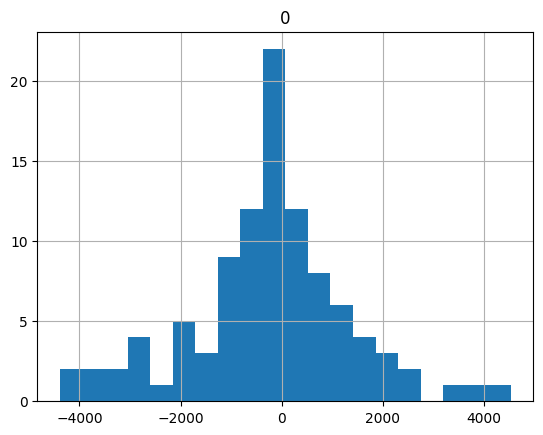

In [4]:
df.hist(bins=20)

Jak widać z tego histogramu, wyniki zagęszczają się bliżej wartości `0`, ale są również wyniki położone dość
daleko wartości `0`, np.:

In [5]:
df.abs().max()

0    4535
dtype: int64

## Synchronizacja wątków (p. 3)

W przypadku zsynchronizowanych wątków, zgodnie z oczekiwaniami na wyjściu za każdym razem dostajemy `0`:

In [6]:
df_sync = pd.read_csv("output_sync.txt", header=None)
print(df_sync)

    0
0   0
1   0
2   0
3   0
4   0
.. ..
95  0
96  0
97  0
98  0
99  0

[100 rows x 1 columns]


In [12]:
df_sync[df_sync == 0]

,0
0,0
1,0
2,0
3,0
4,0
...,...
95,0
96,0
97,0
98,0


Jak widać z powyższego wyniku, wszystkie `100` wartości są równe `0`.

# Wnioski

- **Race condition** czyli **Wyścig**, charakteryzuje się niedeterministycznym zachowaniem programu,
  może powodować błędy trudne do wykrycia i pojawia się wtedy, gdy więcej niż jeden wątek
  korzysta jednocześnie z zasobu dzielonego, przy czym co najmniej jeden próbuje go zmienić;

- Język `Java` posiada własne mechanizmy synchronizacji, między innymi: semafory (`Semaphore`), lockery
  (np. `ReentrantLock`), zmienne atomowe (atomics, np. `AtomicInteger`), słowo kluczowe `synchronized`;

- Stosując modyfikator `volatile`, wszystkie zmiany dokonane na tych zmiennych będą przekazywane do
  innych wątków;

- Niezsynchronizowany dostęp do licznika powoduje wyścigi, w związku z czym nie otrzymujemy na wyjściu
  oczekiwanej wartości, tzn. `0`;

- Zsynchronizowany dostęp do licznika nie powoduje żadnych race condition i na wyjściu za każdym razem
  wypisuje się wartość oczekiwana, czyli `0`.

# Bibliografia

1. [Materiały do laboratorium](https://home.agh.edu.pl/~funika/tw/lab1/)
2. [The Java™ Tutorials - Synchronization](https://docs.oracle.com/javase/tutorial/essential/concurrency/sync.html)
3. [Java Docs - Semaphore](https://docs.oracle.com/javase/8/docs/api/java/util/concurrent/Semaphore.html)
4. [Java Docs - ReentrantLock](https://docs.oracle.com/javase/8/docs/api/java/util/concurrent/locks/ReentrantLock.html)
5. [Java Docs - AtomicInteger](https://docs.oracle.com/javase/8/docs/api/java/util/concurrent/atomic/AtomicInteger.html)
6. [Java Docs - Thread](https://docs.oracle.com/javase/8/docs/api/java/lang/Thread.html)
7. [Baeldung - Guide to the Volatile Keyword in Java](https://www.baeldung.com/java-volatile)
8. [Wikipedia - Race condition](https://en.wikipedia.org/wiki/Race_condition)
9. [Wikipedia - Busy waiting](https://en.wikipedia.org/wiki/Busy_waiting)